In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.metrics import accuracy_score

# Merge results

In [2]:
results = pd.read_csv("data/processed/test.csv")

In [3]:
RoBERTa_base = pd.read_csv("output/RoBERTa_base.csv")
results = pd.merge(results, RoBERTa_base, on = 'review_id')

if 'Unnamed: 0' in results.columns: results = results.drop(columns=['Unnamed: 0'])

In [4]:
RoBERTa_ft = pd.read_csv("output/RoBERTa_ft.csv")
results = pd.merge(results, RoBERTa_ft, on = 'review_id')

if 'Unnamed: 0' in results.columns: results = results.drop(columns=['Unnamed: 0'])

In [5]:
SiEBERT = pd.read_csv("output/SiEBERT.csv")
results = pd.merge(results, SiEBERT, on = 'review_id')

if 'Unnamed: 0' in results.columns: results = results.drop(columns=['Unnamed: 0'])

In [6]:
GPT = pd.read_csv("output/GPT.csv")
results = pd.merge(results, GPT[["review_id", "GPT"]], on = 'review_id')

if 'Unnamed: 0' in results.columns: results = results.drop(columns=['Unnamed: 0'])

# Compare performances

In [7]:
models = ["RoBERTa_base", "RoBERTa_ft", "SiEBERT", "GPT"]

## Average

In [8]:
accuracies = {model: accuracy_score(results["sentiment"], results[model]) for model in models}
accuracy_avg = pd.DataFrame(accuracies.items(), columns=["Model", "Accuracy"])
accuracy_avg.style.hide(axis="index")

Model,Accuracy
RoBERTa_base,0.917080
RoBERTa_ft,0.915200
SiEBERT,0.957320
GPT,0.930040


## By ratings / sentiments

In [9]:
accuracy_rtg = (
    results.groupby("sentiment")
    .apply(lambda group: {model: accuracy_score([group.name] * len(group), group[model]) for model in models}, include_groups=False)
    .apply(pd.Series)
    .reset_index()
    .set_index("sentiment")
    .T
    .reset_index()
)
accuracy_rtg.rename(columns={"index": "model"}, inplace=True)
accuracy_rtg["average"] = accuracy_rtg.iloc[:, 1:].mean(axis=1)
accuracy_rtg = accuracy_rtg.sort_values(by="average", ascending=True)
accuracy_rtg.style.hide(axis="index")

model,negative,positive,average
RoBERTa_ft,0.892640,0.937760,0.915200
RoBERTa_base,0.871040,0.963120,0.917080
GPT,0.962320,0.897760,0.930040
SiEBERT,0.952000,0.962640,0.957320


In [10]:
accuracy_rtg = (
    results.groupby("rating")
    .apply(lambda group: {model: accuracy_score(group["sentiment"], group[model]) for model in models}, include_groups = False)
    .apply(pd.Series)
).sort_values("rating").reset_index()
accuracy_rtg.style.hide(axis="index")

rating,RoBERTa_base,RoBERTa_ft,SiEBERT,GPT
1,0.949821,0.954998,0.984269,0.980884
2,0.907906,0.936577,0.976977,0.976108
3,0.838253,0.863440,0.944510,0.965762
4,0.720304,0.763567,0.875901,0.911575
7,0.921977,0.857824,0.899870,0.755960
8,0.964912,0.934035,0.966316,0.897193
9,0.973123,0.961604,0.979096,0.935154
10,0.976395,0.965593,0.981796,0.945989


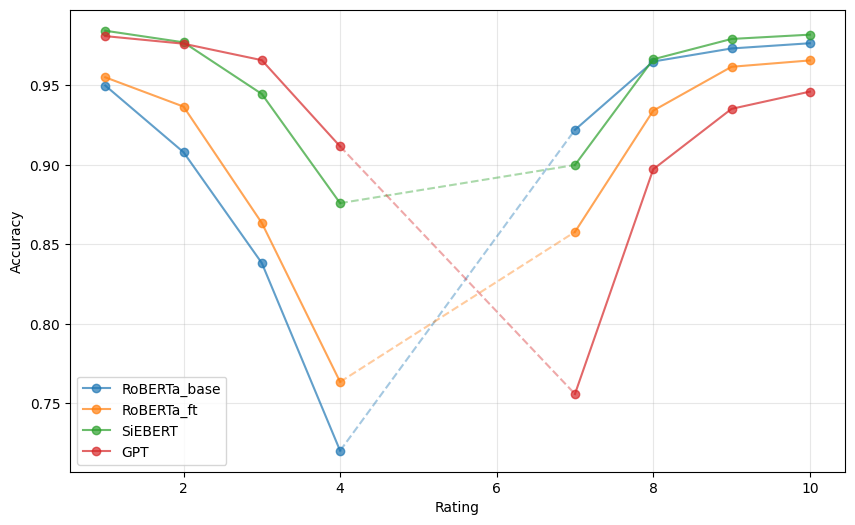

In [11]:
accuracy_long = accuracy_rtg.melt(id_vars="rating", var_name="Model", value_name="Accuracy")

plt.figure(figsize=(10, 6))

# Define a color map for the models
colors = {
    model: plt.cm.tab10(i) for i, model in enumerate(accuracy_long["Model"].unique())
}

# Group by model and plot each group separately
for model in accuracy_long["Model"].unique():
    model_data = accuracy_long[accuracy_long["Model"] == model]
    color = colors[model]
    
    # Split the data into two segments: ratings 1-4 and 7-10
    lower_ratings = model_data[model_data["rating"] <= 4]
    higher_ratings = model_data[model_data["rating"] >= 7]
    
    # Plot each segment with the same color
    plt.plot(lower_ratings["rating"], lower_ratings["Accuracy"], marker="o", linestyle="-", 
             color=color, alpha=0.7, label=model if len(lower_ratings) > 0 else None)
    plt.plot(higher_ratings["rating"], higher_ratings["Accuracy"], marker="o", linestyle="-", 
             color=color, alpha=0.7, label=None)
    
    # Connect the two segments with a styled line to indicate discontinuity if both segments exist
    if len(lower_ratings) > 0 and len(higher_ratings) > 0:
        plt.plot([lower_ratings["rating"].iloc[-1], higher_ratings["rating"].iloc[0]], 
                 [lower_ratings["Accuracy"].iloc[-1], higher_ratings["Accuracy"].iloc[0]], 
                 linestyle="--", alpha=0.4, color=color)

# Add a single legend entry for each model
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

plt.xlabel("Rating")
plt.ylabel("Accuracy")
plt.grid(True, alpha=0.3)

plt.savefig("output/accuracy_vs_ratings.png", dpi=300, bbox_inches='tight')
plt.show()

## By review length

In [21]:
results['nb_words'] = results['text'].apply(lambda x: len(x.split()))

bins = pd.qcut(results["nb_words"], q=10, duplicates="drop")
upper_bounds = np.array([interval.right for interval in bins.cat.categories])
results["max_words"] = upper_bounds[bins.cat.codes]

In [22]:
accuracy_lth = (
    results.groupby("max_words")
    .apply(lambda group: {model: accuracy_score(group["sentiment"], group[model]) for model in models}, include_groups = False)
    .apply(pd.Series)
).reset_index()
accuracy_lth.style.hide(axis="index")

max_words,RoBERTa_base,RoBERTa_ft,SiEBERT,GPT
88.000000,0.925010,0.921476,0.952493,0.933255
117.000000,0.921770,0.914263,0.958119,0.937179
132.000000,0.927782,0.930939,0.965272,0.937253
149.000000,0.922303,0.931562,0.956119,0.931965
170.000000,0.920714,0.920299,0.960980,0.946451
200.000000,0.919152,0.914050,0.958006,0.927002
242.000000,0.919094,0.906553,0.953479,0.926780
310.000000,0.916499,0.911658,0.962485,0.932231
439.000000,0.896359,0.900360,0.951581,0.910764
2235.000000,0.901882,0.900681,0.954746,0.917901


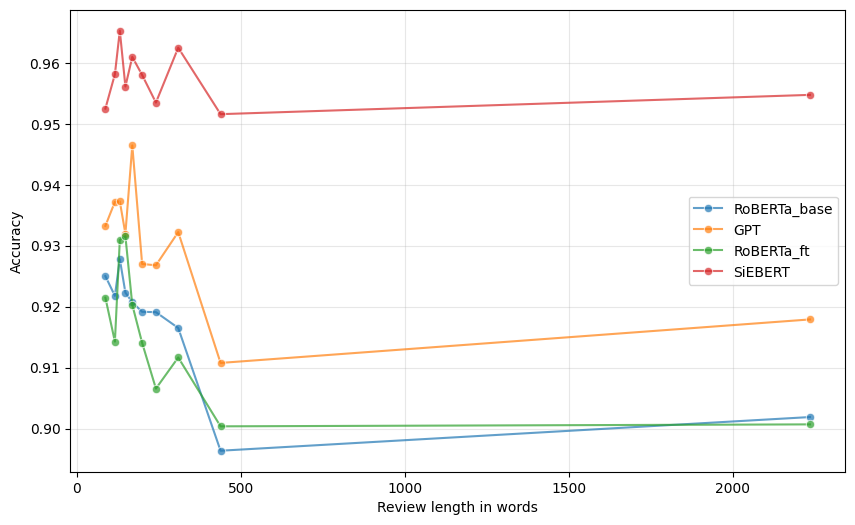

In [23]:
accuracy_long = accuracy_lth.melt(id_vars="max_words", var_name="Model", value_name="Accuracy")
accuracy_long["max_words"] = accuracy_long["max_words"].astype(float)
accuracy_long = accuracy_long.sort_values("max_words")

plt.figure(figsize=(10, 6))
sns.lineplot(data=accuracy_long, x="max_words", y="Accuracy", hue="Model", marker="o", alpha=0.7)
plt.xlabel("Review length in words")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig("output/accuracy_vs_wordcount.png", dpi=300, bbox_inches='tight')
plt.show()